In [44]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from nltk.corpus import gutenberg, stopwords
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Background 

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

In [2]:
# Lets look at what text I can use. 
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [3]:
# Pick 10 different books with 10 different authors.
austen = gutenberg.raw('austen-emma.txt')
bible = gutenberg.raw('bible-kjv.txt')
blake = gutenberg.raw('blake-poems.txt')
bryant = gutenberg.raw('bryant-stories.txt')
buster = gutenberg.raw('burgess-busterbrown.txt')
chesterton = gutenberg.raw('chesterton-thursday.txt')
edgeworth = gutenberg.raw('edgeworth-parents.txt')
milton = gutenberg.raw('milton-paradise.txt')
shakes = gutenberg.raw('shakespeare-caesar.txt')
whitman = gutenberg.raw('whitman-leaves.txt')

# Data Cleaning 

In [4]:
# Utility function to clean text.
def text_cleaner(text):
    
    # Visual inspection shows spaCy does not recognize the double dash '--'.
    # Better get rid of it now!
    text = re.sub(r'--',' ',text)
    
    # Get rid of headings in square brackets.
    text = re.sub("[\[].*?[\]]", "", text)
    
    # Get rid of chapter titles.
    text = re.sub(r'Chapter \d+','',text)
    text = re.sub(r'CHAPTER \d+', '', text)
    text = re.sub("\\n\\n.*?\\n\\n", '', text)
  
    # Get rid of extra whitespace.
    text = ' '.join(text.split())

    
    return text

In [5]:
# Clean documents
austen = text_cleaner(austen)
# Bible was over the limit for nlp so I had to limit it.
bible = text_cleaner(bible)[:99990]
blake = text_cleaner(blake)
bryant = text_cleaner(bryant)
buster = text_cleaner(buster)
chesterton = text_cleaner(chesterton)
edgeworth = text_cleaner(edgeworth)
milton = text_cleaner(milton)
shakes = text_cleaner(shakes)
whitman = text_cleaner(whitman)

In [6]:
# run spaCy and analyze the documents
nlp = spacy.load('en')


austen_doc = nlp(austen)
bible_doc = nlp(bible)
blake_doc = nlp(blake)
bryant_doc = nlp(bryant)
buster_doc = nlp(buster)
chesterton_doc = nlp(chesterton)
edgeworth_doc = nlp(edgeworth)
milton_doc = nlp(milton)
shakes_doc = nlp(shakes)
whitman_doc = nlp(whitman)

In [7]:
# Group into sentences
austen_sents = [[sent, 'austen'] for sent in austen_doc.sents]
bible_sents = [[sent, 'bible'] for sent in bible_doc.sents]
bryant_sents = [[sent, 'bryant'] for sent in bryant_doc.sents]
buster_sents = [[sent, 'buster'] for sent in buster_doc.sents]
chesterton_sents = [[sent, 'chesterton'] for sent in chesterton_doc.sents]
edgeworth_sents = [[sent, 'edgeworth'] for sent in edgeworth_doc.sents]
milton_sents = [[sent, 'milton'] for sent in milton_doc.sents]
shakes_sents = [[sent, 'shakes'] for sent in shakes_doc.sents]
whitman_sents = [[sent, 'whitman'] for sent in whitman_doc.sents]

In [8]:
# Combine the sentences from the 10 novels into one data frame.
sentences = pd.DataFrame(austen_sents + bible_sents + bryant_sents +
                        buster_sents + chesterton_sents + edgeworth_sents +
                        milton_sents + shakes_sents + whitman_sents)

In [14]:
# Add a title to the columns so we know what we are looking at.
sentences.columns = ['text', 'author']

sentences.head()

,text,author
0,"(CHAPTER, I, Emma, Woodhouse, ,, handsome, ,, ...",austen
1,"(She, was, the, youngest, of, the, two, daught...",austen
2,"(Her, mother, had, died, too, long, ago, for, ...",austen
3,"(Sixteen, years, had, Miss, Taylor, been, in, ...",austen
4,"(Between, _, them)",austen


In [15]:
# Add another column turning the author into numbers.
sentences['num_author'] = sentences['author'].map({'austen':1, 'bible':2, 'blake':3,
                                                  'bryant':4, 'buster':5, 'chesterton':6,
                                                  'edgeworth':7, 'milton':8, 'shakes':9,
                                                  'whitman':10})

In [16]:
sentences.head()

,text,author,num_author
0,"(CHAPTER, I, Emma, Woodhouse, ,, handsome, ,, ...",austen,1
1,"(She, was, the, youngest, of, the, two, daught...",austen,1
2,"(Her, mother, had, died, too, long, ago, for, ...",austen,1
3,"(Sixteen, years, had, Miss, Taylor, been, in, ...",austen,1
4,"(Between, _, them)",austen,1


In [17]:
# Look at the size of the data. 
sentences.shape

(37215, 3)

In [18]:
# I tried vectorizing before but the program wouldn't run.
# The error said that it wanted string type data so I checked my data type.
sentences.dtypes

text          object
author        object
num_author     int64
dtype: object

In [19]:
# Originally, sentences was an object type, need to convert it to str type.
sentences['text'] = sentences['text'].astype('str') 
sentences['author'] = sentences['author'].astype('str') 

In [41]:
# Create a training and testing data set. 
X = sentences['text']
y = sentences['num_author']

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Feature Generation

## Tf-idf Vectorization

In [24]:
vectorizer = TfidfVectorizer(max_df=0.5,
                            min_df=4,
                            stop_words='english',
                            lowercase=False,
                            use_idf=True,
                            norm=u'l2',
                            smooth_idf=True)
# Applying the vectorizer
X_tfidf = vectorizer.fit_transform(X)
print('Number of features: {}'.format(X_tfidf.get_shape()[1]))

# Splitting into train and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

# Reshape vectorizer to readable content
X_train_tfidf_csr = X_train_tfidf.tocsr()

# Number of paragraphs
n = X_train_tfidf_csr.shape[0]

# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()

# For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Keep in mind that the log base 2 of 1 is 0, 
# so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[100])
print('Tf_idf vector:', tfidf_bypara[100])


Number of features: 10131
Original sentence: Oh no!
Tf_idf vector: {'Shake': 0.533733191309191, 'Corkscrew': 0.4179025907423565, 'fellow': 0.36685343522395064, 'honest': 0.38448314112456033, 'hands': 0.31609340947531134, 'glad': 0.3499317762019466, 'said': 0.188971651026113}


In [25]:
# Normalize the data.
from sklearn.preprocessing import normalize
X_norm = normalize(X_train_tfidf)

# NLP - spaCy

Rerun NLP in order to tokenize each sentence to be able to extract information about parts of speech to add as features in our models.

In [26]:
# Instantiating spaCy
nlp = spacy.load('en')
X_train_words = []

for row in X_train:
    # Processing each row for tokens
    row_doc = nlp(row)
    # Calculating length of each sentence
    sent_len = len(row_doc) 
    # Initializing counts of different parts of speech
    advs = 0
    verb = 0
    noun = 0
    adj = 0
    for token in row_doc:
        # Identifying each part of speech and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_train_words.append([row_doc, advs, verb, noun, adj, sent_len])

In [27]:
# In order to label each of these new features, I need to re index the y_train data
y_train_new = y_train.reset_index(drop=True)

In [28]:
# Put the new features together with their respective authors.
# Create a data frame for the features first.
txt_bow = pd.DataFrame(data=X_train_words, columns=['BoW', 'Adv', 'Verb', 'Noun',
                                                   'Adj', 'Sent_len'])
# Add the author data into the data frame.
txt_bow = pd.concat([txt_bow, y_train_new], ignore_index=False, axis=1)
txt_bow.head()

,BoW,Adv,Verb,Noun,Adj,Sent_len,author,num_author
0,"(There, had, been, no, real, affection, either...",1,2,3,2,13,austen,1
1,"(The, first, to, speak, was, Gogol, ,, the, ir...",0,4,2,3,18,chesterton,6
2,"(I, swear, I, will, never, henceforth, have, t...",3,9,2,5,32,whitman,10
3,"(`, If, _, Miss, _, _, Taylor, _, undertakes, ...",1,5,5,0,25,austen,1
4,"(If, we, go, anywhere, we, 'll, go, together, ...",2,5,1,0,13,whitman,10


In [29]:
# Okay so I have the boW as features,
# Now I want to obtain the tf-idf features too. 
X_norm_df = pd.DataFrame(data=X_norm.toarray())
txt_tfidf_bow = pd.concat([txt_bow, X_norm_df], ignore_index=False, axis=1)
txt_tfidf_bow.head()

,BoW,Adv,Verb,Noun,Adj,Sent_len,author,num_author,0,1,...,10121,10122,10123,10124,10125,10126,10127,10128,10129,10130
0,"(There, had, been, no, real, affection, either...",1,2,3,2,13,austen,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(The, first, to, speak, was, Gogol, ,, the, ir...",0,4,2,3,18,chesterton,6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"(I, swear, I, will, never, henceforth, have, t...",3,9,2,5,32,whitman,10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"(`, If, _, Miss, _, _, Taylor, _, undertakes, ...",1,5,5,0,25,austen,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"(If, we, go, anywhere, we, 'll, go, together, ...",2,5,1,0,13,whitman,10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
print('Final training dataframe shape:', txt_tfidf_bow.shape)

Final training dataframe shape: (27911, 10139)


In [33]:
# Identifying features and labels to choose from
features = txt_tfidf_bow.drop(['BoW', 'author', 'num_author'], axis=1)
y2_train = txt_tfidf_bow['num_author']

In [34]:
# Theres too many features at the moment, so I will limit it to top 150.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Instantiating and fitting the 150 best features
kbest = SelectKBest(chi2, k=150)
X2_train = kbest.fit_transform(features, y2_train)

# Clustering

The point of using clusters is to group the paragraphs together to see if the clusters group accordingly to their author. There will be several different clustering techniques, the first being

## K-Means Clustering

K-means clustering is an iterative algorithm that seeks to cluster based on minimizing the inertia (cost function) or the sum of squared differences between the mean of the cluster and the data points of the cluster. 

Normally, the data would have to be normalized before using K-Means so that the distance would be accurate but that has already been done up top. 

In [35]:
from sklearn.cluster import KMeans

# I will use 10 clusters because I have 10 authors.
# Initialize the model. 
kmeans = KMeans(n_clusters=10, init='k-means++', random_state=42, n_init=20)

# Fit and predict the model. 
y_pred = kmeans.fit_predict(X2_train)

pd.crosstab(y2_train, y_pred)

col_0,0,1,2,3,4,5,6,7,8,9
num_author,,,,,,,,,,
1,2164,666,20,1896,0,330,105,0,1093,0
2,489,109,0,218,0,36,1,0,202,0
4,610,183,1,720,0,58,2,0,509,0
5,277,61,0,275,0,16,2,0,133,0
6,522,235,0,866,0,60,7,0,622,0
7,2842,797,14,2083,0,332,88,0,1523,1
8,454,371,53,453,0,237,139,0,374,1
9,889,52,0,331,0,9,2,0,143,0
10,1656,478,72,959,4,259,154,1,637,15


In [36]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
# Evaluate the performance of the clusters

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y2_train, y_pred)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(X2_train, y_pred, metric='euclidean')))

Adjusted Rand Score: 0.006425331
Silhouette Score: 0.4459991


Adjusted Rand Index is a function that measures the similarity of two assignments, ignoring permutations and with chance normalization. The score was negative which means that the similarity might as well be random. ARI has an accurate ground truth in the y-pred so it signals that the similarity isn't there.

Silhouette Coefficient is the mean distance between a sample and all other points in the same class (a), the mean distance between a sample and all other points in the next nearest cluster (b), divided by whichever of the two values is highest. Scores around 0 indicate overlapping clusters. Score is higher when clusters are dense and well separated. 

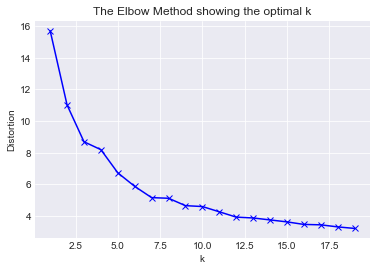

In [54]:
from scipy.spatial.distance import cdist
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X2_train)
    kmeanModel.fit(X2_train)
    distortions.append(sum(np.min(cdist(X2_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X2_train.shape[0])

# Plot the elbow
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow is actually around 6 clusters but I have to use 10 in order to see if the models can label the 10 authors. 

## Mini Batch K Means 

Mini Batch won't really change much since it is only used when PCA isn't run to reduce dimensionality and search for clusters in the reduced data. Mini Batch is useful if I want to keep all the data and if I have limited computational power or time. It works by randomly sampling subsets of the training data in each iteration. 

In [55]:
from sklearn.cluster import MiniBatchKMeans

# Initialize the model. 
minikmeans = MiniBatchKMeans(n_clusters=10, init='k-means++', random_state=42, init_size=1000, batch_size=1000)

# Predict and fit the model. 
y_pred2 = minikmeans.fit_predict(X2_train)

pd.crosstab(y2_train, y_pred2)

col_0,0,1,2,3,4,5,6,7,8,9
num_author,,,,,,,,,,
1,860,518,1121,42,170,1513,320,0,672,1058
2,145,85,443,0,8,83,36,0,131,124
4,412,128,324,1,9,416,70,0,296,427
5,109,47,120,0,6,224,19,0,77,162
6,486,175,221,1,16,464,70,0,366,513
7,1162,610,1815,27,150,1491,350,1,915,1159
8,249,284,215,89,183,309,211,1,247,294
9,136,42,613,0,5,354,8,0,76,192
10,456,361,1094,127,169,798,245,20,406,559


In [56]:
print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y2_train, y_pred2)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(X2_train, y_pred2, metric='euclidean')))

Adjusted Rand Score: 0.007552872
Silhouette Score: 0.3612096


This did slightly worse than k-means but that is to be expected since this is just another rendition of the original k-means model.

## Spectral Clustering

Spectral Clustering is based on quantifying similarity between data points. Spectral clustering takes many different measures of similiarity. The two most common ones are nearest neighbor and the Gaussian kernel of the Euclidean distance. I will put in 10 clusters and the 10 eigenvectors with the 10 largest eigenvalues are extracted and the data is converted to the new 10 dimensional space. This will take a while to run.

In [73]:
# from sklearn.cluster import SpectralClustering
# # Pick the number of clusters.
# n_clusters= 10

# # Initialize the model.
# sc = SpectralClustering(n_clusters=n_clusters)

# # Fit and predict the model.
# y_pred3 = sc.fit_predict(X2_train)

# pd.crosstab(y2_train, y_pred3)

I would've shown the results the spectral clustering model but it took 11 hours and the program was still running. 

## Cluster Analysis

In [57]:
cluster_pred = KMeans(n_clusters=10, random_state=42).fit_predict(features)
X_pred = features.copy()
X_pred['cluster_assignment'] = cluster_pred

cluster_dataframes = {}
for n_clust in range(10):
    cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

for name, frame in cluster_dataframes.items():
    print(name)
    print('\n')
    print(frame.describe())

0


               Adv         Verb         Noun          Adj     Sent_len  \
count  9900.000000  9900.000000  9900.000000  9900.000000  9900.000000   
mean      0.446263     1.065859     0.799899     0.445758     6.232323   
std       0.700281     1.008854     0.886907     0.695030     3.159524   
min       0.000000     0.000000     0.000000     0.000000     1.000000   
25%       0.000000     0.000000     0.000000     0.000000     4.000000   
50%       0.000000     1.000000     1.000000     0.000000     6.000000   
75%       1.000000     2.000000     1.000000     1.000000     9.000000   
max       5.000000     5.000000     6.000000     5.000000    12.000000   

                 0            1            2            3            4  \
count  9900.000000  9900.000000  9900.000000  9900.000000  9900.000000   
mean      0.002687     0.002360     0.002514     0.001979     0.002625   
std       0.047367     0.044323     0.044919     0.040770     0.046339   
min       0.000000     0.000000  

             Adv       Verb        Noun        Adj    Sent_len     0     1  \
count  16.000000  16.000000   16.000000  16.000000   16.000000  16.0  16.0   
mean   11.687500  31.687500   62.812500  26.625000  268.562500   0.0   0.0   
std     6.279265   9.257204   23.235659   7.013083   53.346626   0.0   0.0   
min     1.000000  18.000000   37.000000  18.000000  216.000000   0.0   0.0   
25%     7.750000  25.000000   45.000000  21.500000  237.500000   0.0   0.0   
50%    11.000000  32.500000   61.000000  24.500000  246.000000   0.0   0.0   
75%    14.500000  36.250000   67.750000  32.750000  281.250000   0.0   0.0   
max    28.000000  48.000000  114.000000  38.000000  390.000000   0.0   0.0   

          2     3     4         ...              10122  10123  10124  \
count  16.0  16.0  16.0         ...          16.000000   16.0   16.0   
mean    0.0   0.0   0.0         ...           0.005012    0.0    0.0   
std     0.0   0.0   0.0         ...           0.020049    0.0    0.0   
min     0

            Adv       Verb        Noun        Adj   Sent_len    0    1    2  \
count   5.00000   5.000000    5.000000   5.000000    5.00000  5.0  5.0  5.0   
mean   15.20000  39.000000  163.600000  45.400000  551.80000  0.0  0.0  0.0   
std     9.95992  14.142136   34.107184  18.836135   82.13221  0.0  0.0  0.0   
min     3.00000  24.000000  116.000000  25.000000  423.00000  0.0  0.0  0.0   
25%    11.00000  26.000000  145.000000  31.000000  519.00000  0.0  0.0  0.0   
50%    11.00000  42.000000  168.000000  41.000000  588.00000  0.0  0.0  0.0   
75%    25.00000  45.000000  187.000000  63.000000  606.00000  0.0  0.0  0.0   
max    26.00000  58.000000  202.000000  67.000000  623.00000  0.0  0.0  0.0   

         3    4         ...          10122  10123  10124     10125  10126  \
count  5.0  5.0         ...            5.0    5.0    5.0  5.000000    5.0   
mean   0.0  0.0         ...            0.0    0.0    0.0  0.009821    0.0   
std    0.0  0.0         ...            0.0    0.0    0.0 

There's a problem. For the clusters I don't know what word is what word. To properly show the information of the clusters I will only use the part of speeches. 

## Latent Semantic Analysis

Previously, my data set had a lot of data in it. I decided in order to remedy this by running the LSA which is a dimension reduction technique (PCA) on the tf-idf matrix.

In [58]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 27911 to 10.
svd= TruncatedSVD(10)

# Train the data for features since there's non tf-idf data in the features section.
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(features)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 99.84397238213629
Component 0:
text
For a long, long time the Nightingale sang every evening to the Emperor and his court, and they liked her so much that the ladies all tried to sing like her; they used to put water in their mouths and then make little sounds like this: _glu-glu-glug_.                                                                                                                                      0.999972
Many prudent faces amongst the Fishermen seemed to deliberate at the close of this oration, in which the arguments were brought so "home to each man's business and bosom."                                                                                                                                                                                                                      0.999960
Come Caska, you and I will yet, ere day, See Brutus at his house: three parts of him Is ours alreadie, and the man entire Vpon the 

It captured a lot of the variance of the data, perhaps too much. Lets check the sentence similarity. 

## Sentence Similarity

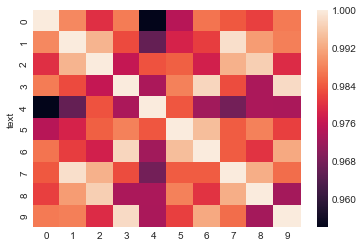

Key:
0 There had been no real affection either in his language or manners.
1 The first to speak was Gogol, the irreconcilable, who seemed bursting with inarticulate grievance. "
2 I swear I will never henceforth have to do with the faith that tells the best, I will have to do only with that faith that leaves the best untold.
3 `If _Miss_ _Taylor_ undertakes to wrap Miss Emma up, you need not have any fears, sir.'
4 If we go anywhere we'll go together to meet what happens,
5 That's well done, Wheeler; fight the by-battle there with Bursal.
6 See, Antony that Reuels long a-nights Is notwithstanding vp.
7 But as for making yourself clear, it is the last thing you do.
8 Not that Emma was gay and thoughtless from any real felicity; it was rather because she felt less happy than she had expected.
9 Let others dispose of questions, I dispose of nothing, I arouse unanswerable questions, Who are they I see and touch, and what about them?


In [59]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

## Supervised Learning Classification Models 

I'm going to attempt the supervised classification models to see how well the different models perform. 

## Random Forest 

In [38]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest model
rfc = RandomForestClassifier()

# Train and fit the model.
train = rfc.fit(X2_train, y2_train)

rfc_scores = cross_val_score(rfc, X2_train, y2_train, cv=5)

print('\nTraining set score without clustering:{:.5f}(+/- {:.3f})'.format(rfc_scores.mean(), rfc_scores.std()*2))


Training set score without clustering:0.48640(+/- 0.011)


## Logistic Regression 

In [42]:
from sklearn.linear_model import LogisticRegression

# Initialize the model.
lr = LogisticRegression()

# Train the model.
train = lr.fit(X2_train, y2_train)

# Obtain the cross val score
lr_scores = cross_val_score(lr, X2_train, y_train, cv=5)
print('\nTraining set score without clustering:{:.5f}(+/- {:.3f})'.format(lr_scores.mean(), lr_scores.std()*2))


Training set score without clustering:0.52621(+/- 0.006)


## Gradient Boosting 

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
train = clf.fit(X2_train, y2_train)
clf_scores = cross_val_score(clf, X2_train, y_train, cv=5)
print('\nTraining set score without clustering:{:.5f}(+/- {:.3f})'.format(clf_scores.mean(), clf_scores.std()*2))


Training set score without clustering:0.54326(+/- 0.012)


## Tuning the hyperparameters

Since the gradient boosting model did the best I will try to increase that model's score for the clustering model.

In [53]:
from sklearn.model_selection import GridSearchCV

# Set of parameters to test for best score in Grid Search CV
clf_params = {'loss':['deviance'],
             'max_depth':[2,4,6],
             'max_features':['auto'],
             'n_estimators':[50,100,200,500]}

#fitting model and printing best parameters and score from model
grid_clf = GridSearchCV(clf, clf_params, cv=5, verbose=1, n_jobs=-1)
grid_clf.fit(X2_train, y_train)

print('Best Score:', grid_clf.best_score_)
best_params_clf = grid_clf.best_params_
print('Best Parameters:', best_params_clf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [102]:
clf2 = GradientBoostingClassifier(loss='deviance', max_depth=2,
                                 max_features='auto', n_estimators=500)

cross_val_score(clf2, X2_train_c, y2_train, cv=5)

array([0.51656222, 0.50984957, 0.51451093, 0.51119871, 0.51460835])

# Conclusion